# Dask imaging demonstration

This notebook explores the use of dask for parallelisation. We work through the steps of imaging, ending up with a major/minor cycle algorithm using dask.

For each step, we first create a graph and then execute it to demonstrate correctness.

In [1]:
%matplotlib inline

import os
import sys

from dask import delayed

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.operations import create_blockvisibility, create_visibility_from_rows, \
    copy_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, \
    create_image_from_visibility, \
    predict_skycomponent_blockvisibility, residual_image, invert_timeslice_single, \
    predict_timeslice_single, predict_timeslice_single, advise_wide_field
from arl.pipelines.dask_graphs import create_invert_graph

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

We create the visibility. 

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')
times = numpy.linspace(-3,+3,13) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e7])


reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame("stokesI"))

create_visibility: 13 rows, 0.016 GB


Create a grid of components and predict each in turn, using the full phase term including w.

In [3]:
npixel = 512
cellsize=0.001
flux = numpy.array([[100.0]])
facets = 4

model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1,
                                    polarisation_frame=PolarisationFrame("stokesI"))
spacing_pixels = npixel // facets
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
comps = list()
for iy in centers:
    for ix in centers:
        pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
        pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comps.append(create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                         polarisation_frame=PolarisationFrame("stokesI")))
vt = predict_skycomponent_blockvisibility(vt, comps)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 10000000.0 Hz
create_image_from_visibility: uvmax = 396.276693 wavelengths
create_image_from_visibility: Critical cellsize = 0.001262 radians, 0.072293 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 128
Component at (63.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 34.4144013, -54.71664839)>
Component at (191.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.55800518, -55.91819473)>
Component at (319.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 8.44199482, -55.91819473)>
Component at (447.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 355.5855987, -54.71664839)>
Component at (63.000000, 191.000000) <SkyCoord (ICRS): (ra, dec) in de

Define a Dask enabled invert looking like invert_2d but with additional arguments for the invert for a single chunk, and the iterator. The iterator is used to split the visibility up into pieces before calling the
single chunk invert.

The function invert_graph is not a graph but it takes graphs as input and emits a graph to do the calculation. The dask.delayed method compute() must be called to actually execute the graph. 

In [4]:
model_graph = delayed(create_image_from_visibility)(vt, npixel=512, cellsize=0.001, npol=1)

def create_invert_graph(vt, model_graph, dopsf=False, normalize=True, invert_single=invert_2d, 
                        iterator=vis_timeslice_iter, **kwargs):
    # When the results are returned from the nodes of the graph, this sums them appropriately
    def accumulate_results(results, normalize=normalize, dopsf=False):
        if dopsf:
            log.info('invert_graph: summing PSFs')
        else:
            log.info('invert_graph: summing dirty images')


        acc = []
        sumwt = 0.0
        nresults = len(results)
        for i, result in enumerate(results):
            if i>0:
                acc.data += result[0].data
                sumwt += result[1]
            else:
                acc = result[0]
                sumwt = result[1]
        
        if normalize:
            acc.data /= float(sumwt)
            
        return acc, sumwt 

    # Make a list of the delayed invert commands. The copy_visibility function executes immediately
    results = list()
    for rows in iterator(vt, **kwargs):
        v = copy_visibility(create_visibility_from_rows(vt, rows))
        result = delayed(invert_single, pure=True)(v, model_graph, dopsf=dopsf, normalize=False, **kwargs)
        results.append(result)

    # We return the delayed accumulate function
    return delayed(accumulate_results, pure=True)(results, normalize, dopsf)

At this point, the model graph is just a delayed function

Delayed('create_image_from_visibility-4895fa7d-0350-4f09-9c28-08da2e8cd148')


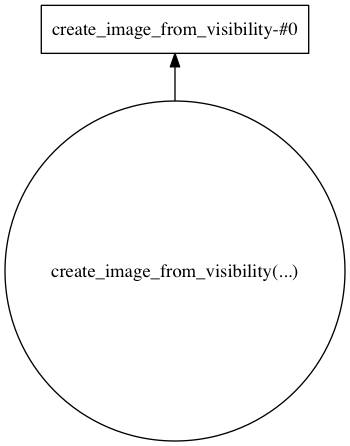

In [5]:
model_graph = delayed(create_image_from_visibility)(vt, npixel=512, cellsize=0.001, npol=1)
print(model_graph)
model_graph.visualize()

So now we can make a graph for a particular context and then visualize it

vis_timeslice_iter: Found 13 unique times
vis_timeslice_auto: Guessing time interval to be 1800.00 s


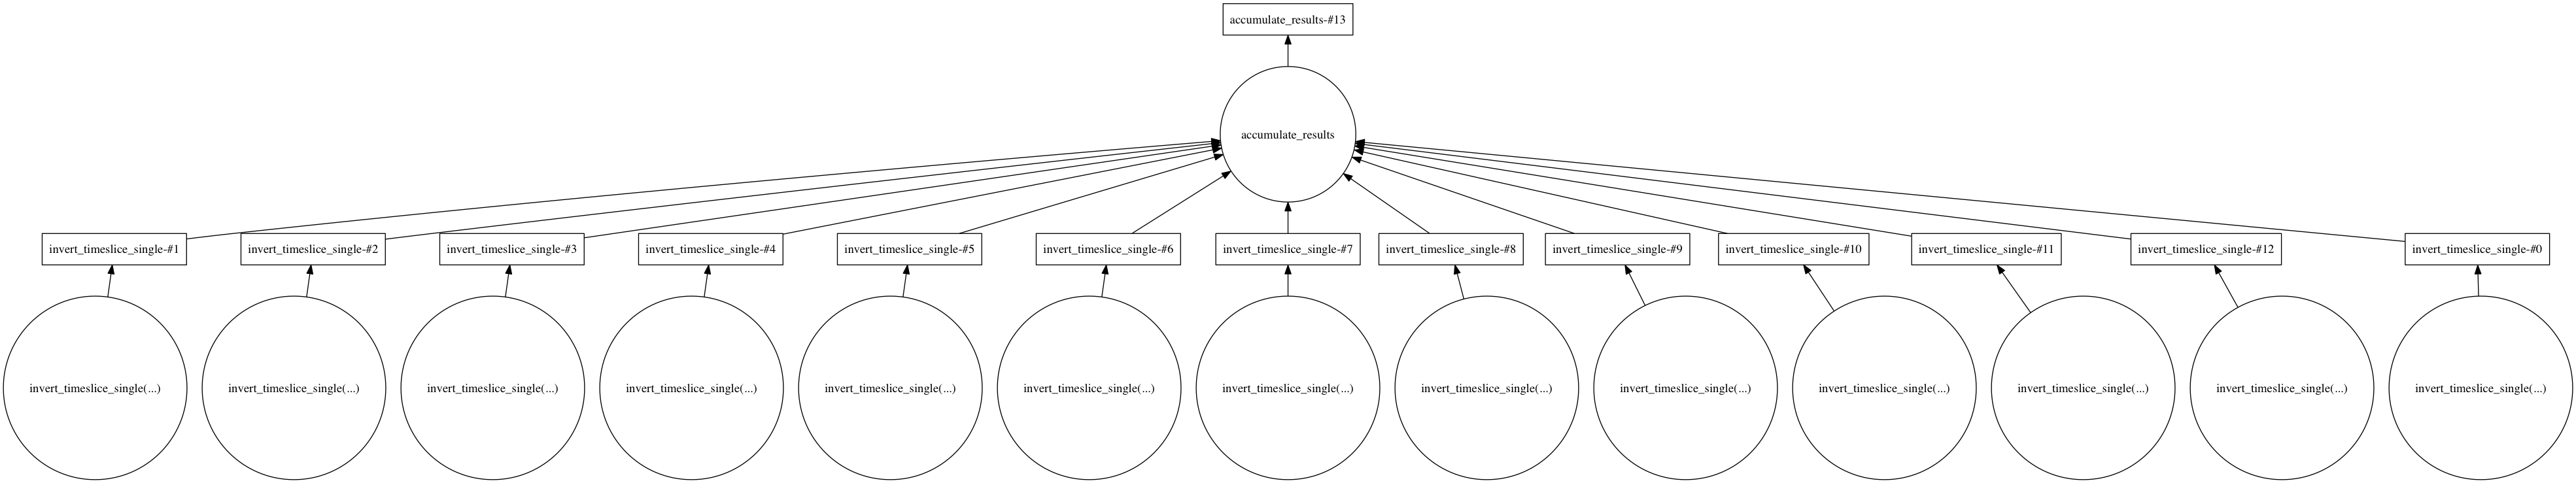

In [6]:
dirty_timeslice_graph = create_invert_graph(vt, model, False, 
                                            invert_single=invert_timeslice_single, 
                                            iterator=vis_timeslice_iter, normalize=False, 
                                            timeslice='auto', context='')
dirty_timeslice_graph.visualize()

In [ ]:
dirty, sumwt=dirty_timeslice_graph.compute()

In [ ]:
show_image(dirty);plt.show()

We will need a deconvolve graph. 

In [ ]:
def create_deconvolve_graph(dirty_graph, psf_graph, model_graph, **kwargs):
    def deconvolve_model_only(dirty, psf, model, **kwargs):
        log.info('deconvolve_graph: Starting deconvolution')
        result = deconvolve_cube(dirty, psf, **kwargs)[0]
        log.info('deconvolve_graph: Finished deconvolution')
        result.data += model.data
        return result
    return delayed(deconvolve_model_only, pure=True)(dirty_graph[0], psf_graph[0], 
                                                                        model_graph, **kwargs)

This will need graphs to calculate the dirty (or residual) image and the psf

In [ ]:
psf_graph = create_invert_graph(vt, model_graph, dopsf=True, invert_single=invert_timeslice_single, 
                                iterator=vis_timeslice_iter, normalize=False, timeslice=10.0)
dirty_graph = create_invert_graph(vt, model_graph, False, invert_single=invert_timeslice_single, 
                                  iterator=vis_timeslice_iter, normalize=False, timeslice=10.0)

We now create and visualize a graph to perform a deconvolution

In [ ]:
clean_model_graph = create_deconvolve_graph(dirty_graph, psf_graph, model_graph, niter=1000, algorithm='hogbom',
                                    gain=0.1)
clean_model_graph.visualize()

Next we will need a graph to calculate residuals. For this we have added a new function in ftprocessor that 
calculates residuals per visibility chunk. This works for timeslicing and wslicing but not for faceting.

In [ ]:
def create_residual_graph(vis, model_graph, iterator=vis_timeslice_iter, **kwargs):

    def accumulate_residuals(results, rowses):
        log.info('residual_graph: summing residual images')
        acc = []
        sumwt = 0.0

        for i, result in enumerate(results):
            if i>0:
                acc.data += result[1].data
                sumwt += result[2]
            else:
                acc = result[1]
                sumwt = result[2]
        
        acc.data /= float(sumwt)
        f=show_image(acc, title="Residual image")
        print(qa_image(acc, context="Residual image"))
        return acc, sumwt

    results = list()
    rowses = list()

    for rows in iterator(vis, **kwargs):
        rowses.append(rows)
        visslice = copy_visibility(create_visibility_from_rows(vis, rows))
        # Each result is tuple: resid vis, resid image, sumwt
        result = delayed(residual_image, pure=True)(visslice, model_graph, normalize=False, **kwargs)
        results.append(result)

    # We return a tuple: resid vis, residual image, sumwt
    return delayed(accumulate_residuals, pure=True)(results, rowses)

Note that the arguments predict_residual and invert_residual are passed to the ftprocessor.residual function.

In [ ]:
residual_timeslice_graph = create_residual_graph(vt, model_graph, 
                                                 predict_residual=predict_timeslice_single, 
                                                 invert_residual=invert_timeslice_single, 
                                                 iterator=vis_timeslice_iter)
residual_timeslice_graph.visualize()

Next we create a function that can make graphs for solve_image

In [ ]:
def create_solve_image_graph(vis, model_graph, psf_graph,
                             create_residual_graph=create_residual_graph, 
                             create_deconvolve_graph=create_deconvolve_graph, **kwargs):

    res_graph_list = list()
    model_graph_list = list()
    
    nmajor = get_parameter(kwargs, "nmajor", 5)
    
    res_graph_list.append(create_residual_graph(vis, model_graph, **kwargs))    
    model_graph_list.append(create_deconvolve_graph(res_graph_list[-1], psf_graph, model_graph, **kwargs))
    
    for cycle in range(1, nmajor):
        res_graph_list.append(create_residual_graph(vis, model_graph_list[-1], **kwargs))    
        model_graph_list.append(create_deconvolve_graph(res_graph_list[-1], psf_graph, 
                                                 model_graph_list[cycle-1], **kwargs))
    
    return model_graph_list[-1]

Now we can create and visualize the graph that will do the deconvolution

In [ ]:
solution_graph = create_solve_image_graph(vt, model_graph=model_graph, psf_graph=psf_graph,
                                          invert_residual=invert_timeslice_single, 
                                          predict_residual=predict_timeslice_single, 
                                          iterator=vis_timeslice_iter, algorithm='hogbom',
                                          niter=1000, fractional_threshold=0.1,
                                          threshold=1.0, nmajor=3, gain=0.1)
solution_graph.visualize()

We update the residual graph and create the restore graph. 

In [ ]:
def create_restore_graph(solution_graph, psf_graph, residual_graph, **kwargs):
    return delayed(restore_cube, pure=True, name='Restore')(solution_graph, psf_graph[0], residual_graph[0], **kwargs)

residual_timeslice_graph = create_residual_graph(vt, solution_graph, 
                                                 predict_residual=predict_timeslice_single, 
                                                 invert_residual=invert_timeslice_single, 
                                                 iterator=vis_timeslice_iter)


restore_graph = create_restore_graph(solution_graph, psf_graph, residual_timeslice_graph)
restore_graph.visualize()

Finally we can execute the restore_graph to obtain the result

In [ ]:
result = restore_graph.compute()

In [ ]:
f=show_image(result, title='Restored clean image')
print(qa_image(result, context='Restored clean image'))